# Generate simulated data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import plotly.express as px
import numpy as np
import statistics as stat
import random
import matplotlib.pyplot as plt
import re
import pysam
import scipy.stats as s
import math
import pickle

# from https://github.com/getzlab/cnv_suite
from cnv_suite import simulate
from cnv_suite import visualize

# Reference data

## Target Interval List

In [3]:
from src.generate_simulated_data import read_target_interval_file
target_interval_file = 'gs://getzlab-workflows-reference_files-oa/hg19/twist/broad_custom_exome_v1.Homo_sapiens_assembly19.targets.interval_list'
target_intervals_df = read_target_interval_file(target_interval_file)

/Users/cchu/Desktop/Methods/SimulatedTumorData/src/generate_simulated_data.py:31: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  target_intervals_df = pd.read_csv(


## Generating germline hetsites from a normal sample

NA12878: Download from HapASeg (https://github.com/getzlab/HapASeg/tree/7ed1298b9ebc7a9f352037638e154c3a20198a54/simulation/NA12878/VCF)

```
! cat broad_custom_exome_v1.Homo_sapiens_assembly19.targets.interval_list | grep -v '^@' > broad_custom_exome_v1.Homo_sapiens_assembly19.targets.interval_list.bed

! cat NA12878/NA12878.vcf | sed 's/^chr//g' | sed 's/^X/23/g' | sed 's/^Y/24/g' > NA12878/NA12878.chr_reformat.vcf

! intersectBed -a NA12878/NA12878.chr_reformat.vcf -b broad_custom_exome_v1.Homo_sapiens_assembly19.targets.interval_list.bed -header > NA12878/NA12878.chr_reformat.subset_broad_custom_exome_v1.Homo_sapiens_assembly19.targets.interval_list.vcf
```

In [4]:
normal_vcf_path = './ref_data/NA12878/NA12878.chr_reformat.subset_broad_custom_exome_v1.Homo_sapiens_assembly19.targets.interval_list.vcf'

## Fasta Files

In [5]:
fasta_file_path = 'gs://getzlab-workflows-reference_files-oa/hg19/Homo_sapiens_assembly19.fasta'
fasta_fai_file_path = 'gs://getzlab-workflows-reference_files-oa/hg19/Homo_sapiens_assembly19.fasta.fai'

local_fasta_file_path = '/Users/cchu/Desktop/Methods/SimulatedTumorData/ref_data/Homo_sapiens_assembly19.fasta'
local_fasta_fai_file_path = '/Users/cchu/Desktop/Methods/SimulatedTumorData/ref_data/Homo_sapiens_assembly19.fasta.fai'

## Gencode gene annotations

For annotation mutations with gene name

Download the gencode gtf file from https://www.gencodegenes.org/human/release_19.html

Run in terminal to unzip the file with only the genes:

```
gunzip -c gencode.v19.annotation.gtf.gz | awk '{if ($3=="gene") {print $0}}' > gencode.v19.annotation.gene_only
```

In [6]:
import os
os.environ['HTSLIB_CONFIGURE_OPTIONS'] = "--enable-gcs"
from src.generate_simulated_data import prep_gencode_gene_df
genes_df = prep_gencode_gene_df(gene_tsv_fn='./ref_data/gencode.v19.annotation.gene_only.tsv')

# Simulate patient1 and samples

In [7]:
from src.generate_simulated_data import Sample, Patient

In [8]:
t1 = Sample(
    name='p1_t1',
    time_point=50, 
    purity=0.7, 
    cov_profile=None, 
    parent_children_clone_ratios={1: [0, 1, 0], 2: [1, 3], 3: [2, 1], 4: [1, 4, 1]}
)
t2 = Sample(
    name='p1_t2',
    time_point=100, 
    purity=0.45, 
    cov_profile=None, 
    parent_children_clone_ratios={1: [0, 1, 0], 2: [1, 1], 3: [5, 1], 4: [0, 1, 1]}
)

t3 = Sample(
    name='p1_t3',
    time_point=120, 
    purity=0.9, 
    cov_profile=None, 
    parent_children_clone_ratios={1: [0, 1, 3], 2: [1, 12], 3: [1, 1], 4: [0, 1, 4]}
)

patient1 = Patient(
    name='patient1', 
    data_directory='/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data',
    samples = [t1, t2, t3],
    num_subclones=7, 
    clone_tree={1: None, 2:1, 3:1, 4:2, 5:4, 6:4, 7:3}, # {child: parent}
)
patient1.set_treatments()
patient1.set_cnv_profile(
    arm_num=20,
    focal_num=3,
    p_whole=0.6,
    ratio_clonal=0.5,
)
patient1.set_sample_cnv_profiles()

loading existing CNV pickle file /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/patient1.cnv_events.pkl


### Ground truth

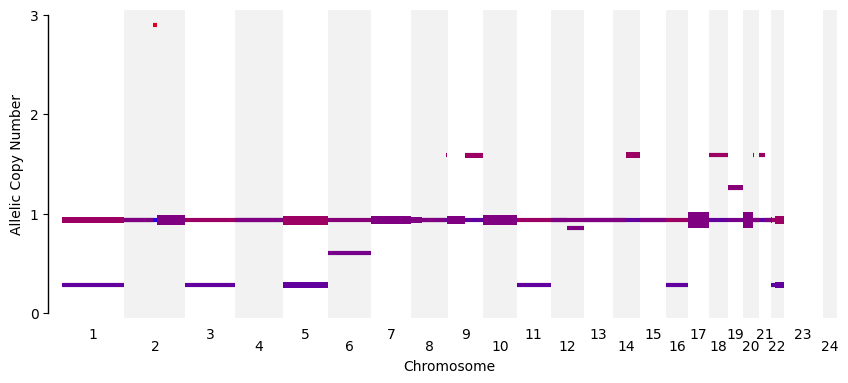

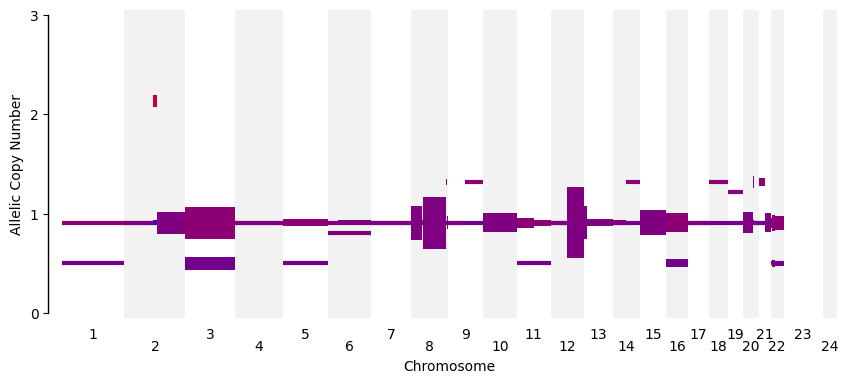

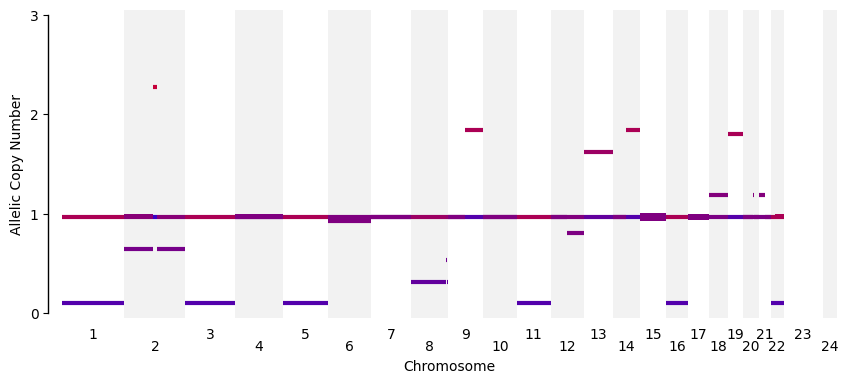

In [9]:
for sample in patient1.samples:
    sample.plot_cn_profile(absolute=False)

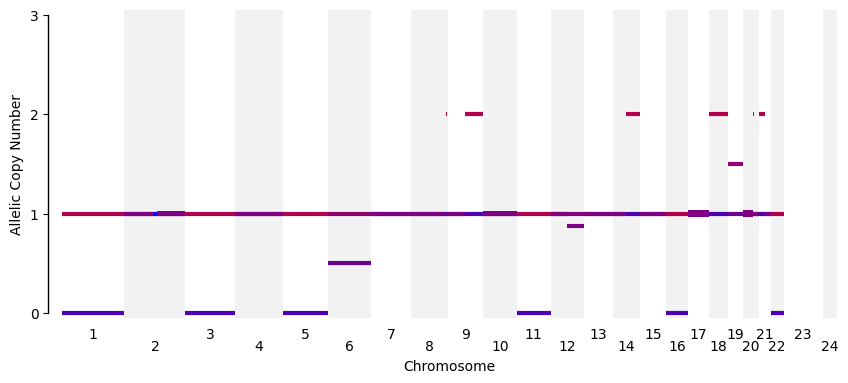

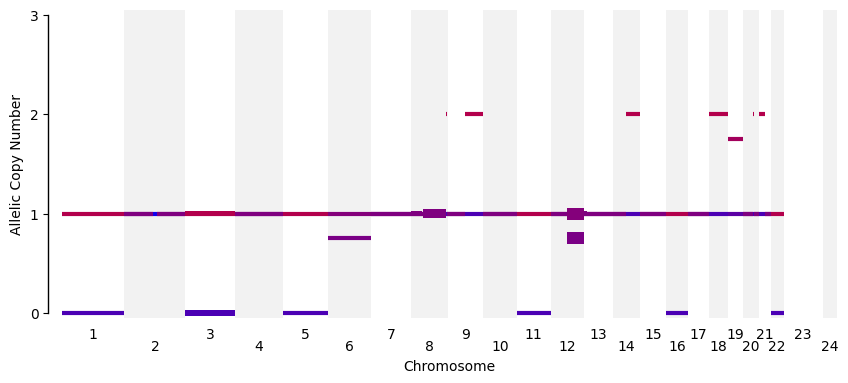

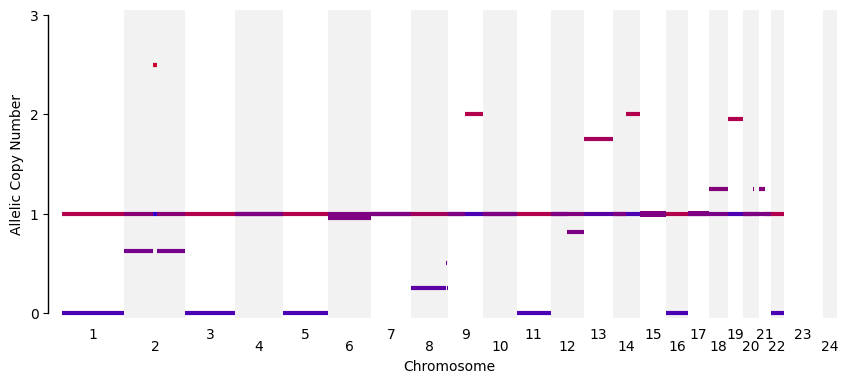

In [10]:
for sample in patient1.samples:
    sample.plot_cn_profile()

In [12]:
patient1.plot_tree(port=8051)

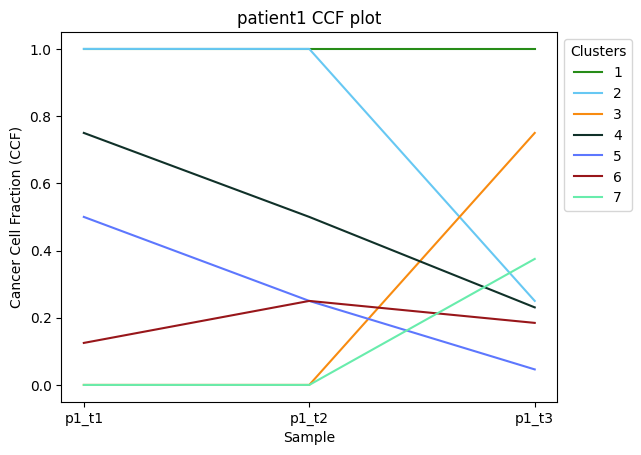

In [13]:
patient1.plot_ccf()

In [15]:
patient1.samples[0].absolute_cnv_profile_df.head()

,Chromosome,Start.bp,End.bp,mu.major,mu.minor,length,n_probes,n_hets,tau,sigma.minor,sigma.major,sigma.tau
0,1,1,249250621,1.0,0.0,249250620,12462,249,1.0,0.012738,0.012738,0.025476
1,2,1,115116963,1.0,1.0,115116962,5755,115,2.0,0.006887,0.006887,0.013775
2,2,115116963,129712734,4.0,1.0,14595771,729,14,5.0,0.004893,0.004893,0.009786
3,2,129712734,243199373,1.0,1.0,113486639,5674,113,2.0,0.021964,0.021964,0.043928
4,3,1,198022430,1.0,0.0,198022429,9901,198,1.0,0.003363,0.003363,0.006726


# Generate simulated data

### Simulate Coverage

In [16]:
patient1.set_sample_coverage(
    target_intervals_df=target_intervals_df, 
    override=False
)

/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_coverage/p1_t1.binned_coverage.tsv already exists.
/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_coverage/p1_t2.binned_coverage.tsv already exists.
/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_coverage/p1_t3.binned_coverage.tsv already exists.


In [17]:
df = pd.read_csv(patient1.samples[0].corrected_binned_coverage_fn, sep='\t')

In [18]:
df.head(3)

,chrom,start,end,covcorr,mean_fraglen,sqrt_avg_fragvar,n_frags,tot_reads,reads_flagged,ploidy,covcorr_original,plus,target_name,interval_length,interval_weight
0,1,65564,65573,702,NaN,NaN,NaN,NaN,NaN,1.3,1080,+,chr1_65564_65573,9,2.595119e-07
1,1,69036,69090,4204,NaN,NaN,NaN,NaN,NaN,1.3,6468,+,chr1_69036_69090,54,1.557071e-06
2,1,69090,70008,71799,NaN,NaN,NaN,NaN,NaN,1.3,110461,+,chr1_69090_70008,918,2.647021e-05


### Simulate CNV het sites

In [19]:
patient1.set_hets_df(
    normal_vcf=normal_vcf_path, 
    target_intervals_df=target_intervals_df
)

Loading existing hets_df from /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/hets.tsv


In [20]:
patient1.set_sample_hets()

Loading /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_hets/p1_t1.hets.tsv
Loading /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_hets/p1_t2.hets.tsv
Loading /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_hets/p1_t3.hets.tsv


#### display hets



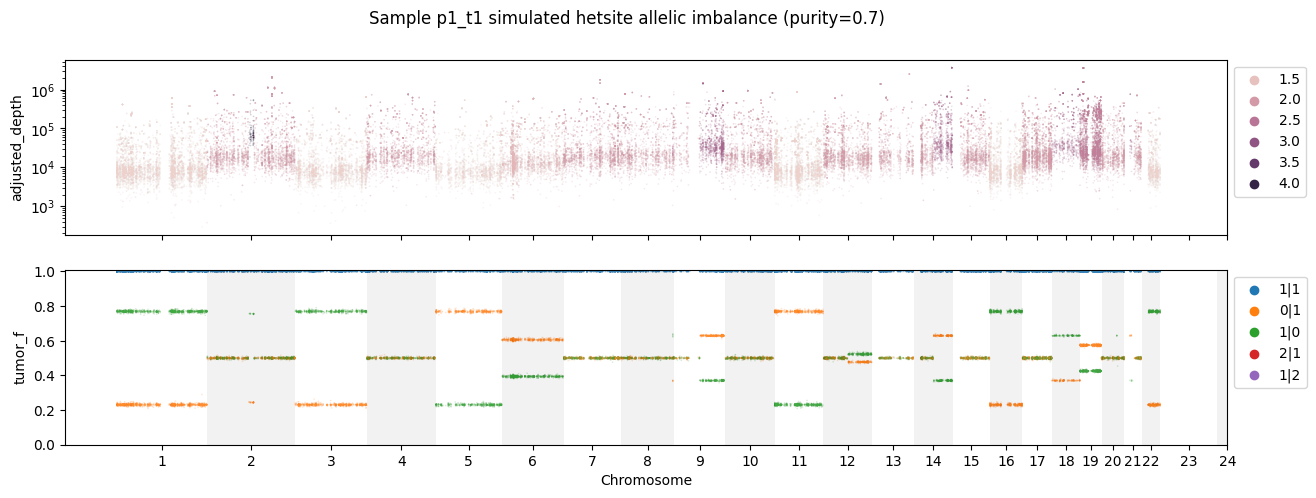

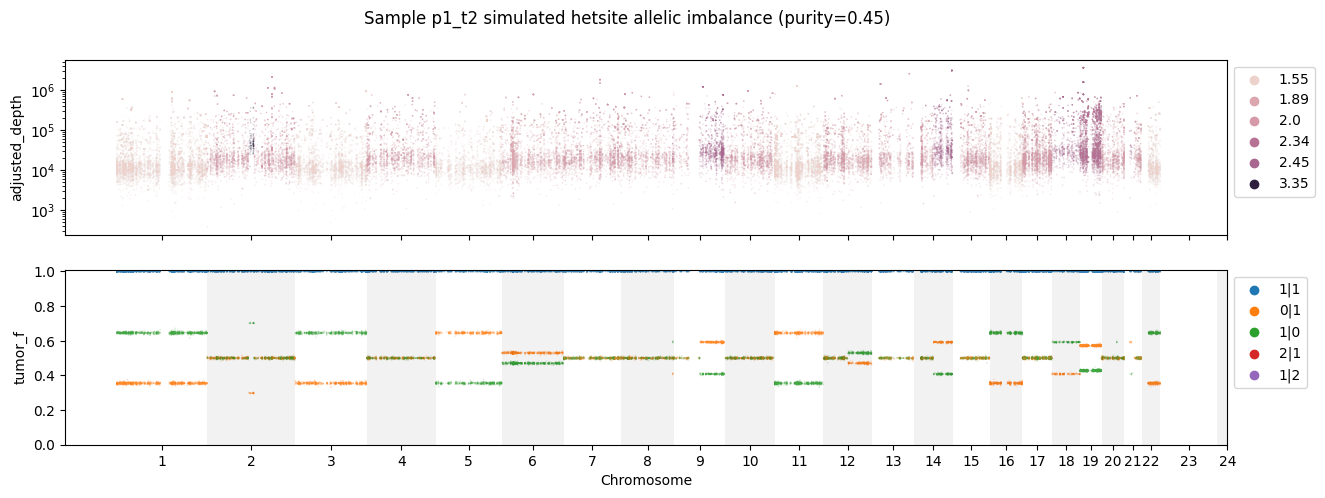

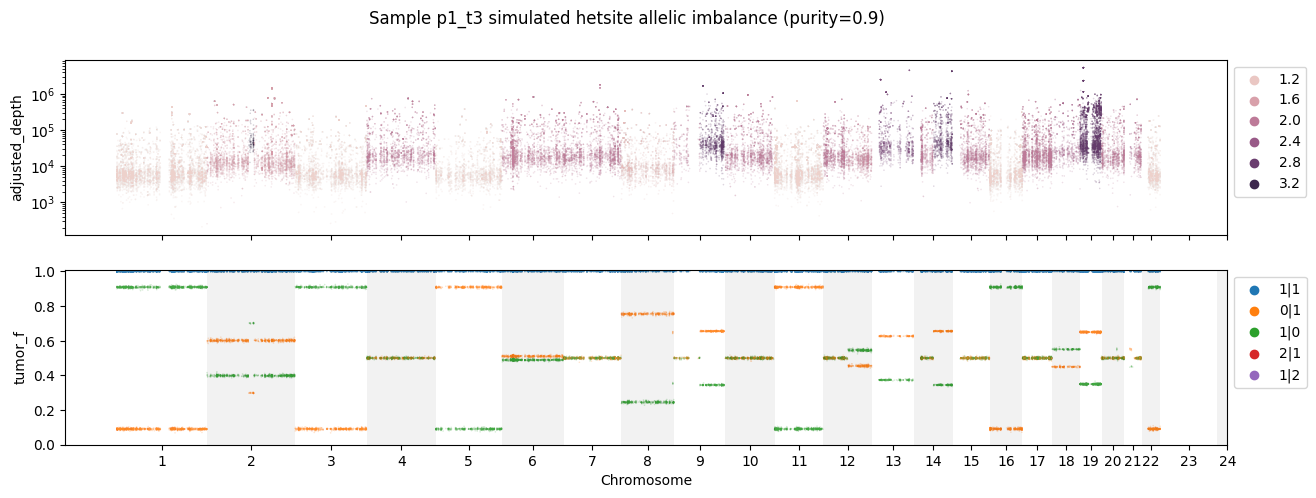

In [18]:
patient1.plot_sample_hets(figsize=(15, 5), size=1)

### Simulate Somatic SNVs

Include gene list to query

In [21]:
patient1.set_variants_df(target_intervals_df, local_fasta_file_path, genes_df, num_variants=100, overwrite=False)

patient variants path exists: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/patient1.variants.tsv


Force add TP53:Y220C mutation to growing clone cluster 3

In [22]:
patient1.force_add_variant(
    target_intervals_df, 
    gene='TP53', 
    chrom='17', 
    pos='7578190', # hg19 coordinate 
    ref_allele='T', 
    alt_allele='C', 
    cluster=3, 
    allele='maternal',
    variant_type='SNP'
)

/Users/cchu/Desktop/Methods/SimulatedTumorData/src/generate_simulated_data.py:1117: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [23]:
patient1.variants_df

,interval,chrom,pos,ref_allele,alt_allele,cluster,allele,Variant_Type,gene
0,chr1_222800916_222803731,1,222803207,A,G,3,paternal,SNP,MIA3
1,chr6_36993567_36993714,6,36993628,A,T,7,paternal,SNP,FGD2
2,chr3_52966077_52966324,3,52966158,T,A,4,paternal,SNP,SFMBT1
3,chr19_14000000_14001275,19,14000618,C,G,1,maternal,SNP,C19orf57
4,chr1_233393773_233395090,1,233394701,A,T,4,maternal,SNP,PCNXL2
...,...,...,...,...,...,...,...,...,...
96,chr17_9603488_9603566,17,9603498,T,A,3,paternal,SNP,USP43
97,chr10_24923939_24924032,10,24923955,C,T,3,maternal,SNP,ARHGAP21
98,chr11_5067755_5068691,11,5068464,A,C,2,maternal,SNP,OR52J3
99,chr17_18217912_18218092,17,18218028,G,C,6,maternal,SNP,TOP3A


### Simulate counts for each sample

In [122]:
patient1.set_sample_muts(overwrite=False)

Sample p1_t1 has variants_fn: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_muts/p1_t1.variants.tsv
Sample p1_t2 has variants_fn: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_muts/p1_t2.variants.tsv
Sample p1_t3 has variants_fn: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_muts/p1_t3.variants.tsv


### Maf2VCF

SNVMerger

In [123]:
patient1.data_directory

'/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1'

In [124]:
local_fasta_file_path

'/Users/cchu/Desktop/Methods/SimulatedTumorData/ref_data/Homo_sapiens_assembly19.fasta'

In [125]:
patient1.set_sample_maf2vcf(
    write_vcf_header_path='/Users/cchu/Desktop/Methods/SimulatedTumorData/src/write_vcf_header.py', 
    local_fasta_file_path=local_fasta_file_path, 
    local_fasta_fai_file_path=local_fasta_fai_file_path, 
)

### Annotate mafs

I used https://www.snp-nexus.org/v4/ and passed one of the sample vcf files

Settings: hg19

Saved as Gene/Protein Consequences with RefSeq 

### Append results to maf

In [160]:
patient1.set_sample_maf_annot(nexus_snp_refseq_annot_tsv=f'{patient1.data_directory}/refseq_SimulatedTumor_patient1.txt')

In [161]:
patient1.samples[0].annot_variants_df.Variant_Classification.value_counts()

nonsyn              51
syn                 10
intronic             9
nonsyn:stop-gain     3
5upstream            2
5utr                 2
3downstream          2
3utr                 1
*syn                 1
Name: Variant_Classification, dtype: int64

In [162]:
patient1.samples[0].annot_variants_df

,Hugo_Symbol,Chromosome,Start_position,Reference_Allele,Tumor_Seq_Allele2,Variant_Type,t_alt_count,t_ref_count,n_alt_count,n_ref_count,...,CDNA Position,CDS Position,AA Position,AA Change,Detail,Splice Distance,Proteins,Variant_Classification,Protein_Change,UniProt_AApos
0,FGD2,6,36993628,A,T,SNP,0.0,100.0,0,100.0,...,1690,1519,507,N>Y,nonsyn,None,MKGASEEKLASVSNLVTVFENSRTPEAAPRGQRLEDVHHRPECRPP...,nonsyn,p.N507Y,507
1,C19orf57,19,14000618,C,G,SNP,37.0,104.0,0,141.0,...,None,None,None,None,NaN,2981,None,intronic,NaN,NaN
2,PCNXL2,1,233394701,A,T,SNP,28.0,50.0,0,78.0,...,1142,907,303,S>T,nonsyn,None,MVSQVLQLLRQGVWAALTGGWYHDPEQSKFTNSCHLYLWLFLLLLP...,nonsyn,p.S303T,303
3,RANBP6,9,6014284,A,G,SNP,43.0,77.0,0,120.0,...,242,None,None,None,NaN,None,None,3utr,NaN,NaN
4,L3MBTL1,20,42143973,C,G,SNP,48.0,116.0,0,164.0,...,534,425,142,S>C,nonsyn,None,MRRREGHGTDSEMGQGPVRESQSSDPPALQFRISEYKPLNMAGVEQ...,nonsyn,p.S142C,142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,MBTPS2,23,21875555,G,C,SNP,0.0,151.0,0,151.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,USP43,17,9603498,T,A,SNP,0.0,120.0,0,120.0,...,1563,1467,489,H>Q,nonsyn,None,MDLGPGDAAGGGPLAPRPRRRRSLRRLFSRFLLALGSRSRPGDSPP...,nonsyn,p.H489Q,489
83,ARHGAP21,10,24923955,C,T,SNP,0.0,120.0,0,120.0,...,833,346,116,A>T,nonsyn,None,MMATRRTGLSEGDGDKLKACEVSKNKDGKEQSETVSLSEDETFSWP...,nonsyn,p.A116T,116
84,TOP3A,17,18218028,G,C,SNP,7.0,113.0,0,120.0,...,None,None,None,None,NaN,None,None,5upstream,NaN,NaN


# Run phylogic

In [30]:
patient1.generate_phylogicNDT_sif()

Generated sif file: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/patient1.phylogicNDT.sif


You can make a python2 environment with conda.

`conda create --name <your_env> python=2.7`

Install PhylogicNDT (from README.md file):
```
cd src/PhylogicNDT
conda activate <your_env>
pip install setuptools wheel
pip install -r req
pip install pandas==0.19.2 scipy==1.0.0 matplotlib==2.0.0
pip install -e git+https://github.com/rmcgibbo/logsumexp.git#egg=sselogsumexp   #for faster compute
```

To get the path:
1. `conda activate <your_env>`
2. `which python` will print out your path (ie `/Users/cchu/opt/anaconda3/envs/phylogicNDT_py27_env/bin/python`)

In [31]:
patient1.run_phylogicNDT(
    python2_path='/Users/cchu/opt/anaconda3/envs/phylogicNDT_py27_env/bin/python',
    phylogicNDT_py_path='/Users/cchu/Desktop/Methods/SimulatedTumorData/src/PhylogicNDT/PhylogicNDT.py',
    num_iterations=1000,
    overwrite=False,
)

Phylogic results are already loaded here: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/phylogicNDT_results_1000


# Run ABSOLUTE

Install R: https://www.r-project.org/

In [179]:
patient1.run_ABSOLUTE_samples(
    R_path='Rscript',
    absolute_split_maf_indel_snp_python_path="./src/ABSOLUTE/src/split_maf_indel_snp.py",
    absolute_dir='./src/ABSOLUTE/v1.5',
    run_cmds=False
)

Not running commands. Outputs in /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_ABSOLUTE_results/p1_t1/ABSOLUTE_results
Not running commands. Outputs in /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_ABSOLUTE_results/p1_t2/ABSOLUTE_results
Not running commands. Outputs in /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_ABSOLUTE_results/p1_t3/ABSOLUTE_results


In [180]:
patient1.samples[0].pp_modes_data_fn

'/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_ABSOLUTE_results/p1_t1/ABSOLUTE_results/p1_t1.PP-modes.data.RData'

# Set up CancerPatientReviewer Data

In [181]:
patient1.set_up_cancer_patient_reviewer_data()

Generated cancer_patient_reviewer_sample_data_fn: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/cancer_patient_reviewer_data/patient1_samples_data.tsv
Generated cancer_patient_reviewer_patient_data_fn: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/cancer_patient_reviewer_data/patient1_data.tsv


# More Patients

In [187]:
t1_2 = Sample(
    name='p2_t1',
    time_point=100, 
    purity=0.5, 
    cov_profile=None, 
    parent_children_clone_ratios={1: [0, 1, 1], 3: [2, 1, 0]}
)
t2_2 = Sample(
    name='p2_t2',
    time_point=150, 
    purity=0.85, 
    cov_profile=None, 
    parent_children_clone_ratios={1: [0, 1, 2], 3: [1, 1, 1]}
)

t3_2 = Sample(
    name='p2_t3',
    time_point=180, 
    purity=0.2, 
    cov_profile=None, 
    parent_children_clone_ratios={1: [0, 1, 2], 3: [0, 1, 4]}
)

patient2 = Patient(
    name='patient2', 
    data_directory='/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data',
    samples = [t1_2, t2_2, t3_2],
    num_subclones=5, 
    clone_tree={1: None, 2:1, 3:1, 4:3, 5:3}, # {child: parent}
)
patient2.set_all_data_part1(
    arm_num=15,
    focal_num=6,
    p_whole=0.8,
    ratio_clonal=0.8,
    target_intervals_df=target_intervals_df,
    normal_vcf_path=normal_vcf_path,
    local_fasta_file_path=local_fasta_file_path,
    local_fasta_fai_file_path=local_fasta_fai_file_path,
    genes_df=genes_df,
    num_variants=200,
    force_add_variants=[
        {'gene': 'RUNX1', 'chrom': '21', 'pos': 36164431, 'ref_allele': 'A', 'alt_allele': 'T', 'cluster': 5, 'allele': 'maternal'}
    ],
    # python2_path='/Users/cchu/opt/anaconda3/envs/phylogicNDT_py27_env/bin/python',
    # phylogicNDT_py_path='/Users/cchu/Desktop/Methods/SimulatedTumorData/src/PhylogicNDT/PhylogicNDT.py',
    write_vcf_header_path='/Users/cchu/Desktop/Methods/SimulatedTumorData/src/write_vcf_header.py',
    overwrite=False
)

patient2.set_all_data_part2(
    use_annot_variants=True,
    nexus_snp_refseq_annot_tsv='/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient2/refseq_SimulatedTumor_patient2.txt',
    python2_path='/Users/cchu/opt/anaconda3/envs/phylogicNDT_py27_env/bin/python',
    phylogicNDT_py_path='/Users/cchu/Desktop/Methods/SimulatedTumorData/src/PhylogicNDT/PhylogicNDT.py',
    overwrite=False,
    R_path='Rscript',
    absolute_split_maf_indel_snp_python_path="./src/ABSOLUTE/src/split_maf_indel_snp.py",
    absolute_dir='./src/ABSOLUTE/v1.5',
)

loading existing CNV pickle file /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient2/patient2.cnv_events.pkl
/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient2/sample_coverage/p2_t1.binned_coverage.tsv already exists.
/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient2/sample_coverage/p2_t2.binned_coverage.tsv already exists.
/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient2/sample_coverage/p2_t3.binned_coverage.tsv already exists.
patient variants path exists: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient2/patient2.variants.tsv
Sample p2_t1 has variants_fn: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient2/sample_muts/p2_t1.variants.tsv
Sample p2_t2 has variants_fn: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient2/sample_muts/p2_t2.variants.tsv
Sample p2_t3 has variants_fn: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient2/sample_muts/p2_t3.variants.tsv


/Users/cchu/Desktop/Methods/SimulatedTumorData/src/generate_simulated_data.py:1157: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Run /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient2/sample_mut_vcf/p2_t1.variants.vcf through (nexus-snp hg19 RefSeq).
Generated sif file: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient2/patient2.phylogicNDT.sif
Phylogic results are already loaded here: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient2/phylogicNDT_results_1000
Not running commands. Outputs in /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient2/sample_ABSOLUTE_results/p2_t1/ABSOLUTE_results
Not running commands. Outputs in /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient2/sample_ABSOLUTE_results/p2_t2/ABSOLUTE_results
Not running commands. Outputs in /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient2/sample_ABSOLUTE_results/p2_t3/ABSOLUTE_results
Generated cancer_patient_reviewer_sample_data_fn: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient2/cancer_patient_reviewer_data/patient2_samples_data.tsv
Generated cancer_

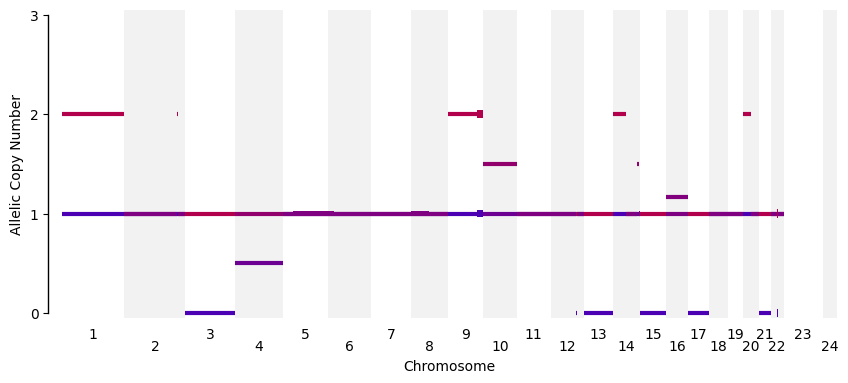

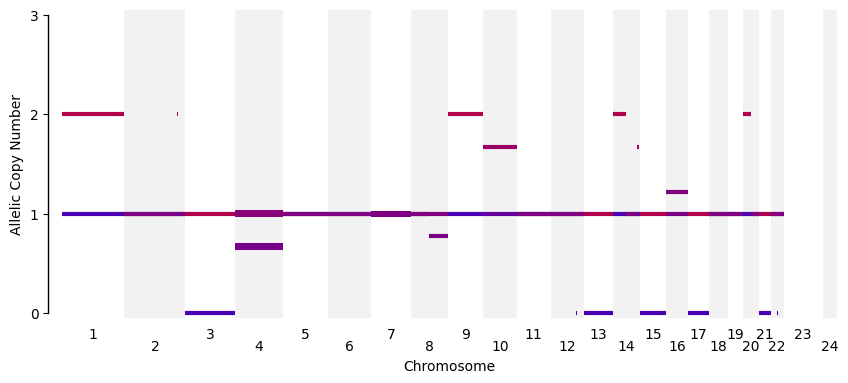

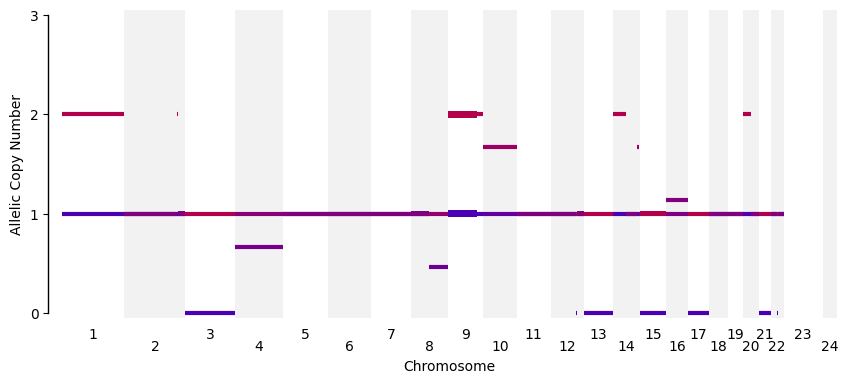

In [34]:
for sample in patient2.samples:
    sample.plot_cn_profile(absolute=True, interactive=False)

In [35]:
patient2.plot_tree()

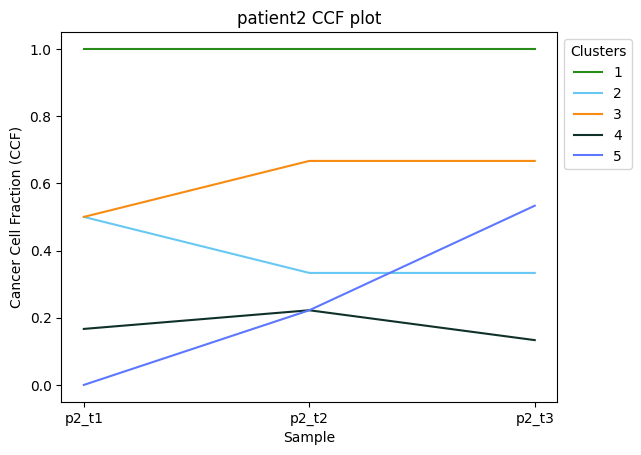

In [36]:
patient2.plot_ccf()

# Pickle Patients

In [42]:
patient1.phylogicNDT_results_dir

'/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/phylogicNDT_results_1000'

In [51]:
patients_df = pd.DataFrame()
patients = [patient1, patient2]
for patient in patients:
    patient_pkl = f'{patient.data_directory}/{patient.name}.pkl'
    with open(patient_pkl, 'wb') as fh:
        pickle.dump(patient, fh)
    patients_df.loc[patient.name, 'pickle_object_fn'] = patient_pkl
    

In [52]:
patients_pkl_fn = './sim_data/patients_pickle_objects.tsv'
patients_pkl_fn

'./sim_data/patients_pickle_objects.tsv'

In [53]:
patients_df.to_csv(patients_pkl_fn, sep='\t')

# Load patients

In [34]:
def load_patient_pkl_fn(pkl_fn):
    with open(pkl_fn, 'rb') as fh:
        patient = pickle.load(fh)

    patient.data_directory = pkl_fn.rsplit('/', 1)[0]
    patient.set_all_data()
    return patient

# insert your local path to sim_data
path_to_sim_data = '/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data'
patient_names = ['patient1', 'patient2'] # or pass in list of patients from patients_pkl_fn
loaded_patients = [
    load_patient_pkl_fn(f'{path_to_sim_data}/{patient_name}/{patient_name}.pkl') for patient_name in patient_names
]

loading existing CNV pickle file /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/patient1.cnv_events.pkl
/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_coverage/p1_t1.binned_coverage.tsv already exists.
/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_coverage/p1_t2.binned_coverage.tsv already exists.
/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_coverage/p1_t3.binned_coverage.tsv already exists.
patient variants path exists: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/patient1.variants.tsv
Sample p1_t1 has variants_fn: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_muts/p1_t1.variants.tsv
Sample p1_t2 has variants_fn: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_muts/p1_t2.variants.tsv
Sample p1_t3 has variants_fn: /Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/sample_muts/p1_t3.variants.tsv
Generated sif 

In [35]:
loaded_patients[0].patient_reviewer_patient_data_fn

'/Users/cchu/Desktop/Methods/SimulatedTumorData/sim_data/patient1/patient_reviewer_data/patient1_data.tsv'

In [36]:
df = pd.read_csv(loaded_patients[0].patient_reviewer_patient_data_fn, sep='\t')
df

,participant_id,maf_fn,cluster_ccfs_fn,build_tree_posterior_fn,tumor_molecular_subtype,tumor_morphology,tumor_primary_site,cancer_stage,vital_status,death_date_dfd,follow_up_date,age_at_diagnosis,gender,notes,treatments_fn
0,patient1,/Users/cchu/Desktop/Methods/SimulatedTumorData...,/Users/cchu/Desktop/Methods/SimulatedTumorData...,/Users/cchu/Desktop/Methods/SimulatedTumorData...,Unknown,Unknown,NaN,NaN,NaN,NaN,NaN,32,NaN,NaN,/Users/cchu/Desktop/Methods/SimulatedTumorData...


# OLD KRISTY SIMULATION

## Helpful methods for CNV_Profile and Phylogeny classes in cnv_suite

In [27]:
# add methods to simulate.CNV_Profile().phylogeny to set the phylogeny manually

def set_phylogeny(self, phylogeny_dict):
    self.num_subclones = phylogeny_dict['num_subclones']
    self.parents = phylogeny_dict['parents']
    self.ccfs = phylogeny_dict['ccfs']
    
def get_children(self, node):
    """Return children for the specified clone
        
    :param node: index of desired clone
    :return: (dict) representing the child clones and their respective CCFs"""

    cluster_list=[]
    for k, v in self.parents.items():
        if v==node:
            cluster_list.append(k)

    return cluster_list
    
simulate.cnv_profile.Phylogeny.set_phylogeny = set_phylogeny
simulate.cnv_profile.Phylogeny.get_children = get_children

In [28]:
# add methods to simulate.CNV_Profile().CNV_Profile to get and set the cnv events manually

def set_events_and_phylogeny(self, event_trees, phylogeny):
    self.event_trees = event_trees
    self.phylogeny =  phylogeny
    
def pickle_events(self, out_file_name):
    event_trees = self.event_trees
    
    # open a file, where you ant to store the data
    file = open(out_file_name, 'wb')
    pickle.dump(event_trees, file)
    file.close()
    
simulate.cnv_profile.CNV_Profile.pickle_events = pickle_events
simulate.cnv_profile.CNV_Profile.set_events_and_phylogeny = set_events_and_phylogeny

## Set output folder and reference data folder

In [29]:
output_folder = './output_data'

## Populate reference data folder

In [30]:
# need to implement streaming directly from the cloud...for now just download target intervals, fasta, fasta index, and fasta dict locally

target_interval_file = 'gs://getzlab-workflows-reference_files-oa/hg19/twist/broad_custom_exome_v1.Homo_sapiens_assembly19.targets.interval_list'
# fasta_file_path = 'gs://getzlab-workflows-reference_files-oa/hg19/Homo_sapiens_assembly19.fasta'
# fasta_index_file_path = 'gs://getzlab-workflows-reference_files-oa/hg19/Homo_sapiens_assembly19.fasta.fai'
# fasta_dict_file_path = 'gs://getzlab-workflows-reference_files-oa/hg19/Homo_sapiens_assembly19.dict'

reference_folder = './reference_files'
#target_interval_file = f'{reference_folder}/hg19_twist_broad_custom_exome_v1.Homo_sapiens_assembly19.targets.interval_list'
fasta_file_path = f'{reference_folder}/hg19_Homo_sapiens_assembly19.fasta'

## Simulated treatments data for phylogic treatment bars 

In [31]:
treatments = pd.DataFrame({
    'participant_id': ['patient1', 'patient1'],
    'categories': ['Chemotherapy', 'Precision/Targeted therapy'],
    'drugs': ['Trastuzumab', 'Neratinib'],
    'drug_combination': [np.nan, np.nan],
    'start_date_dfd': [100, 200],
    'stop_date_dfd': [200, 300],
    'stop_reason': ['Unknown', 'Unknown'],
    'pre_status': [np.nan, np.nan],
    'post_status': ['Unknown', 'Unknown'],
    'notes': [np.nan, np.nan]
})

treatments.to_csv(f'{output_folder}/patient1_treatments.txt', sep='\t', index=False)

OSError: Cannot save file into a non-existent directory: 'output_data'

## Set phylogeny for simulated patients

In [ ]:
# generate phylogeny
patient_id = 'patient1'
sample_id_dict = {'t1': f'{patient_id}_t1', 't2': f'{patient_id}_t2', 't3': f'{patient_id}_t3'}

timepoints_dict = {'t1': 0, 't2': 100, 't3': 300}

clones_dict = {'num_subclones': 6,
                       'parents': {1: None, 2:1, 3:1, 4:2, 5:4, 6:4, 7:3}
                      }

# be careful when setting your own phylogeny that the ccfs are consistent:
# at all time points, the ccfs of a clone must be greater than or equal to the sum of the ccfs of its children

ccfs_dict = {'t1': {1:1.0, 2:0.9,  3:0.1,  4:0.8,  5:0.15,  6:0.1,  7:0.05},
             't2': {1:1,   2:0.95, 3:0.05, 4:0.9,  5:0.3,   6:0.05, 7:0.03},
             't3': {1:1,   2:0.3,  3:0.6,  4:0.1,  5:0.05,  6:0.03, 7:0.45}
            }
purity_dict = {'t1': 0.7, 't2': .45, 't3':.9}

timepoints=list(ccfs_dict.keys())

phylogeny_dict={}

for t in timepoints:
    phylogeny = simulate.CNV_Profile().phylogeny
    phy_dict = clones_dict
    phy_dict['ccfs'] = ccfs_dict[t]
    phylogeny.set_phylogeny(phy_dict)
    phylogeny_dict[t] = phylogeny

## Generate CNV profiles

In [ ]:
# Generate copy number events, then store so they can be reloaded for each timepoint.
# Note: CNV_Profile.event_trees are specific to the phylogeny, so don't reuse them if you change that, just generate new ones

### generate ###

# patient1_cnv_profile = simulate.CNV_Profile()
# patient1_cnv_profile.phylogeny = p1_t1_phy
# patient1_cnv_profile.add_cnv_events(arm_num=20, focal_num=600, p_whole=0.6, ratio_clonal=0.5,
#                        median_focal_length=1.8 * 10**6)
# patient1_cnv_profile.pickle_events('p1_cnv_events_600_focal_20_arm.pkl')

################

##### load #####

file = open(f'{output_folder}/p1_cnv_events_600_focal_20_arm.pkl', 'rb')
event_trees = pickle.load(file)
file.close()

################

In [ ]:
# generate a cnv_profile for each timepoint, 
# using defined phylogeny and event_trees loaded from pickle file

cnv_profiles_dict={}

for t in timepoints:
    cnv_profile = simulate.CNV_Profile()
    cnv_profile.set_events_and_phylogeny(event_trees,phylogeny_dict[t])
    cnv_profile.calculate_profiles()
    
    cnv_profile.cnv_profile_df['n_probes'] = random.choices(population=range(3, 5875), k=len(cnv_profile.cnv_profile_df))
    cnv_profile.cnv_profile_df['length'] = random.choices(population=range(600, 100000000), k=len(cnv_profile.cnv_profile_df))
    cnv_profile.cnv_profile_df['tau'] = random.choices(population=np.arange(0, 6, 0.0000001), k=len(cnv_profile.cnv_profile_df))
    cnv_profile.cnv_profile_df['sigma.minor'] = np.random.exponential(0.01, size=len(cnv_profile.cnv_profile_df))
    cnv_profile.cnv_profile_df['sigma.major'] = np.random.exponential(0.01, size=len(cnv_profile.cnv_profile_df))

    cnv_profile.cnv_profile_df.reset_index(drop=True, inplace=True)
    # ensure sigma minor is smaller than sigma major
    for row in range(len(cnv_profile.cnv_profile_df)):
        if cnv_profile.cnv_profile_df.loc[row, 'sigma.minor'] > cnv_profile.cnv_profile_df.loc[row, 'sigma.major']:
            lower = cnv_profile.cnv_profile_df.loc[row, 'sigma.major']
            cnv_profile.cnv_profile_df.loc[row, 'sigma.major'] = cnv_profile.cnv_profile_df.loc[row, 'sigma.minor']
            cnv_profile.cnv_profile_df.loc[row, 'sigma.minor'] = lower
    
    cnv_profiles_dict[t] = cnv_profile

## Save copy number seg files

In [ ]:
cnv_file_dict={}

for t in timepoints:
    fn = f'simulated_seg.{t}.tsv'
    cnv_profiles_dict[t].cnv_profile_df.to_csv(f'{output_folder}/{fn}', index=False, sep='\t')
    cnv_file_dict[t] = fn

In [ ]:
cnv_profiles_dict['t1'].cnv_profile_df

## Display CNV profiles

In [ ]:
for t in timepoints:

    fig, ax = plt.subplots(1,1)
    fig = visualize.plot_cnv_profile.plot_acr_static(cnv_profiles_dict[t].cnv_profile_df, 
                                                     ax, cnv_profile.csize, 
                                                     segment_colors='difference', 
                                                     sigmas=False, 
                                                     min_seg_lw=3, 
                                                     y_upper_lim=3)


## Get target intervals and fasta file

In [ ]:
target_interval_file

In [ ]:
target_intervals_df = pd.read_csv(target_interval_file,sep='\t', comment='@', 
                                 names=['chrom', 'start', 'stop', 'plus','target_name'])

In [ ]:
target_intervals_df = target_intervals_df[(target_intervals_df.chrom!='MT') & 
                                          (target_intervals_df.chrom!='Y') & 
                                          (target_intervals_df.chrom!='GL000228.1')]
target_intervals_df = target_intervals_df.rename(columns={'stop':'end'})
target_intervals_df['chrom'] = target_intervals_df['chrom'].apply(lambda x: '23' if x=='X' else str(x))

In [ ]:
target_intervals_df['interval_length']=target_intervals_df['end']-target_intervals_df['start']
total_intervals_length = target_intervals_df['interval_length'].sum()
target_intervals_df['interval_weight'] = target_intervals_df['interval_length']/total_intervals_length

In [ ]:
target_intervals_df['chrom'] = target_intervals_df['chrom'].astype(str)
target_intervals_df['start'] = target_intervals_df['start'].astype(int)
target_intervals_df['end'] = target_intervals_df['end'].astype(int)

In [ ]:
target_intervals_df.head()

## Generate coverage

## Combine corrected coverage with other interval metrics

In [ ]:
# Only run once to generate, later need to load saved binned coverage instead

### generate ###

# sigma = 2
# x_coverage = 120

# binned_coverage_dict = {}

# for t in timepoints:
#     binned_coverage_df = target_intervals_df[['chrom','start','end']].copy()
#     dispersion_norm = np.random.normal(0, sigma, binned_coverage_df.shape[0])
#     binned_coverage = x_coverage * (binned_coverage_df['end'] - binned_coverage_df['start'])
#     this_chr_coverage = np.asarray([np.random.poisson(cov + np.exp(disp)) for cov, disp in
#                                    zip(binned_coverage, dispersion_norm)])
#     binned_coverage_df['cov'] = this_chr_coverage
#     binned_coverage_df.to_csv(f'{output_folder}/binned_coverage.{str(t)}.tsv', sep='\t', index=False, header=False)
#     binned_coverage_dict[t] = binned_coverage_df

################

##### load #####

binned_coverage_dict = {}

for t in timepoints:
    binned_coverage_dict[t] = pd.read_csv(f'{output_folder}/binned_coverage.{str(t)}.tsv', sep='\t', header=None, names=['chrom','start','end','cov'] )

################

In [ ]:
corrected_binned_coverage_dict = {}

for t in timepoints:
    corrected_binned_coverage_df = cnv_profiles_dict[t].generate_coverage(purity_dict[t], f'{output_folder}/binned_coverage.{str(t)}.tsv')
    corrected_binned_coverage_df['chrom'] = corrected_binned_coverage_df['chrom'].astype(str)
    corrected_binned_coverage_df['start'] = corrected_binned_coverage_df['start'].astype(int)
    corrected_binned_coverage_df['end'] = corrected_binned_coverage_df['end'].astype(int)
    
    corrected_binned_coverage_dict[t] = corrected_binned_coverage_df.copy()

In [ ]:
interval_data_dict={}

for t in timepoints:
    interval_data_df = target_intervals_df.merge(corrected_binned_coverage_dict[t], on=['chrom', 'start', 'end'])
    interval_data_dict[t] = interval_data_df.copy()

## Generate SNVs

In [ ]:
def get_alt_allele(ref_allele):
    possible_alleles = ['C', 'G', 'A', 'T']
    possible_alleles.remove(ref_allele)
    allele_index = random.choices(population=range(0,3), k=1)[0]
    
    return possible_alleles[allele_index]

def get_chrom_pos(interval, interval_data_df, fasta_file_path):
    interval_row = interval_data_df[interval_data_df.target_name==interval].iloc[0]
    
    #chrom = target_intervals_df.loc[interval,'chrom']
    #start = target_intervals_df.loc[interval,'start']
    #stop = target_intervals_df.loc[interval,'stop']
    
    chrom = interval_row['chrom']
    
    if chrom == '23':
        chrom = 'X'
    
    start = interval_row['start']
    end = interval_row['end']
    pos = random.choices(population=range(start,end), k=1)[0]

    ref_base_str = pysam.faidx(fasta_file_path, str(chrom)+':'+str(pos)+'-'+str(pos))
    ref_base = ref_base_str[-2]
    alt_base = get_alt_allele(ref_base)
    
    if chrom == 'X':
        chrom = '23'
    
    
    
    return chrom, pos, ref_base, alt_base



In [ ]:
# Only run once to generate SNVs, later need to load saved SNVs instead

### generate ###

# num_variants = 100
# variants_df = pd.DataFrame(index=range(num_variants))

# variants_df['interval'] = random.choices(population=target_intervals_df.target_name, weights=target_intervals_df.interval_weight, k=num_variants)
# variants_df[['chrom','pos', 'ref_allele', 'alt_allele']] = variants_df.apply(lambda x: get_chrom_pos(x.interval, interval_data_df, fasta_file_path), axis=1, result_type='expand')
# variants_df['cluster'] = variants_df.apply(lambda x: random.choices(range(cnv_profiles_dict[timepoints[0]].phylogeny.num_subclones))[0]+1, axis=1)
# variants_df['allele'] = variants_df.apply(lambda x: 'maternal' if random.choices(range(2))[0]==0 else 'paternal', axis=1)

# variants_df.to_csv(f'{output_folder}/variants.tsv', sep='\t', index=False)

################

##### load #####

variants_df = pd.read_csv(f'{output_folder}/variants.tsv', sep='\t')

################

In [ ]:
variants_df

## Add local ploidy, coverage, overlapping copy number events, multiplicity trees, vafs, and alt/ref counts to variants dataframes


Now that every mutation is assigned a cluster, we know what its cancer cell fraction is.  Given CCF, coverage, purity, and ploidy, we need to determine the variant allele fraction.

The vaf is determined by calculating the average number of copies of the mutation in all of the clusters, and adding up their contributions scaled by the CCF.  This value is scaled by the purity to obtain the average number of copies of the mutation per cell for the entire sample.  When divided by the local ploidy, this gives the variant allele fraction.

Given the true variant allele fraction, the alt and ref counts are determined by drawing from a binomial distribution with a mean of the vaf and a variance inversely proportional to the coverage.

In [ ]:
def get_cov_and_ploidy(interval, interval_data_df):
    interval_row = interval_data_df[interval_data_df.target_name==interval].iloc[0]
    
    start = interval_row['start']
    end = interval_row['end']
    avg_covcorr = round(interval_row['covcorr']/(end-start))
    ploidy = interval_row['ploidy']
    
    return int(avg_covcorr), ploidy

def get_overlapping_events(mut, cnv_profile):
    chrom = str(mut.chrom)
    # if chrom=='X':
    #     chrom='23'
    
    if mut.allele=='paternal':
        events = cnv_profile.event_trees[chrom].paternal_tree.at(mut.pos)
        alt_allele_events = cnv_profile.event_trees[chrom].maternal_tree.at(mut.pos)
    elif mut.allele=='maternal':
        events = cnv_profile.event_trees[chrom].maternal_tree.at(mut.pos)
        alt_allele_events = cnv_profile.event_trees[chrom].paternal_tree.at(mut.pos)
    return events, alt_allele_events

def get_mut_and_unmut_copies_in_clone(upstream_mut, upstream_unmut, events, mut, clone):
    cn_change = 0
    is_possible = True
    
    unmut_copies = upstream_unmut
    mut_copies = upstream_mut
    
    for event in events:
        if (event.data.type!= 'haploid') & (event.data.cluster_num==clone):
            cn_change += event.data.cn_change
            
    if cn_change + upstream_mut + upstream_unmut < 0:
        raise Exception("Invalid CNAs!")
    
    # when examining a clone that the mutation doesn't occur in
    if mut.cluster!=clone: 
        
        # if copy gain, amplify mutated allele if one exists
        if cn_change > 0:
            if  mut_copies>0:
                mut_copies = upstream_mut + cn_change
            else:
                unmut_copies = upstream_unmut + cn_change 
            
        # if copy loss, delete unmutated allele if one exists
        elif cn_change < 0:
            if unmut_copies>0:
                unmut_copies = upstream_unmut + cn_change
            else:
                mut_copies = upstream_mut + cn_change
            
    # when examining the clone where the mutation occurs
    else:
        if upstream_mut !=0:
            print("Warning: Possibly overlapping mutations: already mutated copies at mutation event!")
            print(f'clone: {clone}')
        if (cn_change < 0) &  (upstream_unmut + cn_change <= 0) :
            print("No copies of allele left to mutate!")
            is_possible = False
        else:
            
            # if overlapping CN amplification event in same clone
            if cn_change > 0:
                mut_copies += 1+cn_change
                unmut_copies += -1
                
            # if overlapping CN deletion event in same clone...should I even allow this?
            elif cn_change < 0:
                mut_copies += 1
                unmut_copies += -1 + cn_change
                
            # if no overlapping CN event in same clone
            elif cn_change == 0:
                mut_copies += 1
                unmut_copies -= 1
        
    if mut_copies < 0:
        print("Can't have a negative number of mutated alleles!")
        is_possible = False
    if unmut_copies < 0:
        print("Can't have a negative number of unmutated alleles!")
        is_possible = False
    return mut_copies, unmut_copies, is_possible

def get_mut_multiplicity(mut, phylogeny):
    
    # mut is a series with: interval, chrom, pos, avg_covcorr, ploidy, ref_allele, cluster, allele, overlapping_CN_events
    print(f'chrom: {mut.chrom}, pos: {mut.pos}, cluster: {mut.cluster}, allele: {mut.allele}')
    
    mut_multiplicity_dict = {}
    
    for node in phylogeny.ccfs.keys():
        if node == 1:
            unmut_copies = 1
        else:
            unmut_copies = 0

        mut_multiplicity_dict[node]={'mut_copies':0, 'unmut_copies':unmut_copies}
    
    # iterate through nodes in the tree from top down 
    # such that every parent node is complete before any of it's children
    
    children = [1]
    nodes_calculated = []
    
    while children:
        new_children = []
        for child in children:
            
            if child!=1:
                parent = phylogeny.parents[child]
                upstream_mut = mut_multiplicity_dict[parent]['mut_copies']
                upstream_unmut = mut_multiplicity_dict[parent]['unmut_copies']
            else:
                upstream_mut = 0
                upstream_unmut = 1 # assume normal cells have one copy of each allele
            
            mut_num, unmut_num, is_possible = get_mut_and_unmut_copies_in_clone(upstream_mut,
                                                                   upstream_unmut, 
                                                                   mut.overlapping_CN_events, 
                                                                   mut,
                                                                   child)
            if not is_possible:
                return None
            else:
                mut_multiplicity_dict[child]['mut_copies'] = mut_num
                mut_multiplicity_dict[child]['unmut_copies'] = unmut_num
            
            new_children = new_children + phylogeny.get_children(child)
            nodes_calculated.append(child)
        children = new_children
    
    return mut_multiplicity_dict

def get_true_vaf(mut, phylogeny, purity):
    if mut.multiplicity is not None:
        total_mut_copies = 0
        for node in mut.multiplicity:
            node_fraction = phylogeny.ccfs[node]
            for child in phylogeny.get_children(node):
                node_fraction -= phylogeny.ccfs[child]
            total_mut_copies += node_fraction*mut.multiplicity[node]['mut_copies']*purity
        vaf = total_mut_copies/mut.ploidy
        if vaf > 1:
            raise Exception("More mutated copies than local ploidy!")
        return vaf
    else:
        return None
    
def get_alt_count(mut):
    if not math.isnan(mut.vaf):
        t_alt_count = round(s.binom.rvs(int(mut.avg_covcorr), mut.vaf, size=1)[0])
        return int(t_alt_count)
    
def get_local_allelic_cn(mut, ccfs, purity):
    a1 = 0
    a2 = 0
    
    for i in mut.overlapping_CN_events:
        a1 += i.data.cn_change*ccfs[i.data.cluster_num]
    for i in mut.alt_overlapping_CN_events:
        a2 += i.data.cn_change*ccfs[i.data.cluster_num]
    a1 = a1*purity+2*(1-purity)
    a2 = a2*purity+2*(1-purity)

    return a1, a2

In [ ]:
variants_dict = {}
for t in timepoints:
    variants_df[['avg_covcorr', 'ploidy']] = variants_df.apply(lambda x: get_cov_and_ploidy(x.interval, interval_data_dict[t]), axis=1, result_type='expand')
    variants_df[['overlapping_CN_events','alt_overlapping_CN_events']] = variants_df.apply(lambda x: get_overlapping_events(x, cnv_profiles_dict[t]), axis=1, result_type='expand')
    variants_df['multiplicity'] = variants_df.apply(lambda x: get_mut_multiplicity(x, cnv_profiles_dict[t].phylogeny), axis=1)
    variants_df['vaf'] = variants_df.apply(lambda x: get_true_vaf(x, cnv_profiles_dict[t].phylogeny, purity_dict[t]), axis=1)
    variants_df['t_alt_count'] = variants_df.apply(lambda x: get_alt_count(x), axis=1)
    variants_df['t_ref_count'] = variants_df['avg_covcorr']-variants_df['t_alt_count']
    variants_df[['local_cn_a1','local_cn_a2']] = variants_df.apply(lambda x: get_local_allelic_cn(x, ccfs_dict[t], purity_dict[t]), axis=1, result_type='expand')
    variants_dict[t] = variants_df.copy()
    

## Save maf files

In [ ]:
maf_file_dict={}

for t in timepoints:
    variants_dict[t]['Hugo_Symbol']='Unknown'
    variants_dict[t] = variants_dict[t].rename(columns={'chrom': 'Chromosome', 
                                                        'pos':'Start_position', 
                                                        'ref_allele':'Reference_Allele', 
                                                        'alt_allele':'Tumor_Seq_Allele2'})
    variants_dict[t] = variants_dict[t][['Hugo_Symbol', 
                                         'Chromosome',
                                         'Start_position',
                                         'Reference_Allele',
                                         'Tumor_Seq_Allele2',
                                         't_alt_count',
                                         't_ref_count',
                                         'local_cn_a1',
                                         'local_cn_a2',
                                         'cluster',
                                         'allele',
                                         'avg_covcorr',
                                         'ploidy',
                                         'overlapping_CN_events',
                                         'alt_overlapping_CN_events',
                                         'multiplicity',
                                         'vaf'
                                        ]]
    variants_dict[t]['sample_id'] = f'patient1_{t}'
    variants_dict[t]['participant_id'] = 'patient1'
    fn = f'simulated_maf.{t}.maf'
    variants_dict[t][(~variants_dict['t1'].vaf.isna())].to_csv(f'{output_folder}/{fn}', index=False, sep='\t')
    maf_file_dict[t] = fn
    
    '''
    
    simulated maf file output columns:
         Hugo_Symbol: gene name or "Unknown"
         Chromosome: chromosome number, 23 for X chromosome
         Start_position: mutation position
         Reference_Allele: reference allele at chromosome/start position
         Tumor_Seq_Allele2: simulated alternate allele at chromosome/start position
         t_alt_count: simulated number of alternate reads
         t_ref_count: simulated number of reference reads
         local_cn_a1: local copy number of allele 1 (needed as input to PhylogicNDT if seg files aren't provided)
         local_cn_a2: local copy number of allele 2 (needed as input to PhylogicNDT if seg files aren't provided)
         cluster: simulated cluster assignment (not typically known)
         allele: simulated maternal/paternal allele assignment (not typically known)
         avg_covcorr: simulated coverage
         ploidy: local ploidy (not typically known)
         overlapping_CN_events: interval tree giving CN events that overlap with mutation
         alt_overlapping_CN_events: interval tree giving CN events on opposite allele (maternal/parternal)
         multiplicity: dictionary giving interval multiplicity of mutation in each subclone (not typically known)
         vaf: simulated variant allele fraction
     
     '''

## Concatonate maf files

In [ ]:
# mafs = [f'{output_folder}/simulated_maf.{t}.maf' for t in timepoints]
# patient_maf = pd.concat([pd.read_csv(maf, sep='\t', encoding = "ISO-8859-1") for maf in mafs]).reset_index(drop=True)

In [ ]:
patient_maf = pd.read_csv('./output_data/PhylogicNDT_outputs/patient1.mut_ccfs.txt', sep='\t')

## Get gene names 

In [ ]:
from generate_simulated_data import prep_gencode_gene_df
genes_df = prep_gencode_gene_df(gene_tsv_fn='./ref_data/gencode.v19.annotation.gene_only.tsv')

In [ ]:
# download the file below from https://www.gencodegenes.org/human/release_19.html
# run in terminal to unzip the file with only the genes:
# gunzip -c gencode.v19.annotation.gtf.gz | awk '{if ($3=="gene") {print $0}}' > gencode.v19.annotation.gene_only.tsv

genes = pd.read_csv('gencode.v19.annotation.gene_only.tsv', sep='\t')
genes.loc[len(genes), :] = genes.columns
genes.drop(columns=['HAVANA', 'gene', '.', '+', '..1'], inplace=True)
genes.columns=['Chromosome', 'Start_position', 'End_position', 'data']

chromosome_map = {
    'chr1': 1,
    'chr2': 2,
    'chr3': 3,
    'chr4': 4,
    'chr5': 5,
    'chr6': 6,
    'chr7': 7,
    'chr8': 8,
    'chr9': 9,
    'chr10': 10,
    'chr11': 11,
    'chr12': 12,
    'chr13': 13,
    'chr14': 14,
    'chr15': 15,
    'chr16': 16,
    'chr17': 17,
    'chr18': 18,
    'chr19': 19,
    'chr20': 20,
    'chr21': 21,
    'chr22': 22,
    'chrX': 23,
    'chrY': 24,
    'chrM': 25
}

genes['Chromosome'] = genes['Chromosome'].replace(chromosome_map)
genes['Start_position'] = genes['Start_position'].astype('int')
genes['End_position'] = genes['End_position'].astype('int')

for i in range(len(patient_maf)):
    chrom_genes = genes[genes['Chromosome'] == patient_maf.loc[i, 'Chromosome']].reset_index(drop=True)
    for j in range(len(chrom_genes)):
        if patient_maf.loc[i, 'Start_position'] >= chrom_genes.loc[j, 'Start_position'] and patient_maf.loc[i, 'Start_position'] < chrom_genes.loc[j, 'End_position']:
            patient_maf.loc[i, 'Hugo_Symbol'] = chrom_genes.loc[j, 'data'].split(';')[4].split('"')[1::2][0]

patient_maf.to_csv(f'{output_folder}/patient1_maf.txt', sep='\t', index=False)

## Run PhylogicNDT

In [ ]:
# make PhylogicNDT sif file

sampleIDs = list(sample_id_dict.values())
sample_mafs = list(maf_file_dict.values())
sample_cn_profiles = [''] * len(timepoints)
purities = map(str, list(purity_dict.values()))
times = map(str, list(timepoints_dict.values()))

with open(f'{output_folder}/{patient_id}.sif', 'w') as f:
    f.write('sample_id\tmaf_fn\tseg_fn\tpurity\ttimepoint')
    for line in sorted(zip(sampleIDs, sample_mafs, sample_cn_profiles, purities, times), key=lambda k: (float(k[4]), k[0])):
        f.write('\n'+'\t'.join(line))


In [ ]:
# run the following commands in terminal where PhylogicNDT is installed from the same working directory used here
# python2 /phylogicndt/PhylogicNDT.py Cluster -i "patient1" -sif "patient1.sif" --maf_input_type "calc_ccf" -rb


## Format patient1.sif file for PatientReviewer sample df

In [ ]:
samples = pd.read_csv('./output_data/patient1.sif', sep='\t')
samples['cnv_seg_fn'] = ['../Annomate/simulated_data/output_data/simulated_seg.t1.tsv', '../Annomate/simulated_data/output_data/simulated_seg.t2.tsv', '../Annomate/simulated_data/output_data/simulated_seg.t3.tsv']
samples.drop(['seg_fn'], axis=1, inplace=True)
samples['participant_id'] = ['patient1', 'patient1', 'patient1']
samples['preservation_method'] = [np.nan, np.nan, np.nan]
samples['wxs_ploidy'] = [2, 2, 2]
samples.rename(columns={'purity': 'wxs_purity', 'timepoint': 'collection_date_dfd'}, inplace=True)
samples.to_csv(f'{output_folder}/patient1_samples.tsv', sep='\t', index=False)

## Create participant df with columns to fit expected PatientReviewer format (config output format)

In [ ]:
participant = pd.DataFrame({
    'participant_id': ['patient1'], 
    'maf_fn': ['../Annomate/simulated_data/output_data/patient1_maf.txt'], 
    'cluster_ccfs_fn': ['../Annomate/simulated_data/output_data/PhylogicNDT_outputs/patient1.cluster_ccfs.txt'], 
    'build_tree_posterior_fn': ['../Annomate/simulated_data/output_data/PhylogicNDT_outputs/patient1_build_tree_posteriors.tsv'],
    'tumor_molecular_subtype': 'Unknown',
    'tumor_morphology': 'Unknown',
    'tumor_primary_site': np.nan,
    'cancer_stage': np.nan,
    'vital_status': np.nan,
    'death_date_dfd': np.nan,
    'follow_up_date': np.nan,
    'age_at_diagnosis': 32,
    'gender': np.nan,
    'notes': np.nan,
    'treatments_fn': '../Annomate/simulated_data/output_data/patient1_treatments.txt'
})
participant.to_csv(f'{output_folder}/patient1.tsv', sep='\t', index=False)